In [8]:
import matplotlib.pyplot as plt
import torch

from vap.utils.utils import vad_list_to_onehot, vad_onehot_to_vad_list
from vap.events.new_events import HoldShiftEvents, get_hold_shift_candidates

In [3]:
VL = {
    "shift": [[[0.0, 3.0], [6.5, 8]], [[4.0, 6.0], [9.5, 10]]],
    "shift_pause": [[[0.0, 2.0], [2.6, 3], [6.5, 8]], [[4.0, 6.0], [9.5, 10]]],
    "shift_pause_bad": [
        [[0.0, 2.0], [2.6, 3], [6.5, 8]],
        [[2.1, 2.3], [4.0, 6.0], [9, 10]],
    ],
    "hold": [[[0.0, 5.0], [6.0, 10.0]], []],
    "hold_pause": [[[0.0, 4.0], [4.4, 5], [6.0, 10.0]], []],
    "hold_pause_bad": [[[0.0, 4.0], [4.4, 5], [6.0, 10.0]], [[4.1, 4.3]]],
    "bc": [
        [[0.0, 3.0], [3.2, 7], [8.5, 9.0]],
        [[2.1, 2.5], [4.5, 4.8], [7.8, 10.0]],
    ],
    "shift_overlap": [[[0.0, 3.0], [6.5, 8]], [[2.0, 6.0], [7.5, 10]]],
    "shift_overlap_pause": [
        [[0.0, 1.2], [1.5, 3.0], [6.5, 8]],
        [[2.0, 6.0], [7.5, 10]],
    ],
}
vad_list = [v for _, v in VL.items()]
vad = []
for vl in vad_list:
    vad.append(vad_list_to_onehot(vl, duration=10, frame_hz=50))
vad = torch.stack(vad)

In [4]:
class PE:
    @staticmethod
    def plot_regions(xs, ws, ax, height=1, color="g", frame_hz=50):
        for x, w in zip(xs, ws):
            PE.plot_region(x, w, ax, height=height, color=color, frame_hz=frame_hz)

    @staticmethod
    def plot_region(x, w, ax, height=1, color="g", frame_hz=50):
        x = x / frame_hz
        w = w / frame_hz
        ax.add_patch(
            plt.Rectangle(
                (x, 0),
                width=w,
                height=height,
                edgecolor=color,
                facecolor=color,
                alpha=0.5,
            )
        )

    @staticmethod
    def plot_vad_oh(
        vad, ax, draw_style="horizontal", y=None, color="b", frame_hz=50, linewidth=3
    ):
        t = torch.arange(len(vad)) / frame_hz
        if y is None:
            y0, y1 = ax.get_ylim()
            y = (y0 + y1) / 2

        if draw_style == "horizontal":
            s, d, v = find_island_idx_len(vad)
            s = s[v == 1] - 1
            d = d[v == 1] - 1
            x0 = t[s]
            x1 = t[s + d]
            ax.hlines(
                y=[y] * len(x0), xmin=x0, xmax=x1, color=color, linewidth=linewidth
            )
        elif draw_style == "rectangle":
            s, d, v = find_island_idx_len(vad)
            s = s[v == 1] - 1
            d = d[v == 1] - 1
            x0 = t[s]
            x1 = t[s + d]
            for x0_, x1_ in zip(x0, x1):
                ax.add_patch(
                    plt.Rectangle(
                        (x0_, y),
                        width=x1_ - x0_,
                        height=0.1,
                        linewidth=0,
                        edgecolor=color,
                        facecolor=color,
                    )
                )
        else:
            ax.plot(t, vad, color=color)

    @staticmethod
    def plot_vad_oh_rect(vad, ax, y_center=0.5, height=0.45, alpha=0.6, frame_hz=50):
        vl = vad_onehot_to_vad_list(vad.unsqueeze(0))[0]
        PE.plot_vad_list_rect(vl, ax, y_center=y_center, height=height, alpha=alpha)

    @staticmethod
    def plot_vad_list_rect(vad_list, ax, y_center=0.5, height=0.45, alpha=0.6):
        for ii, ch in enumerate(vad_list):
            y = y_center if ii == 0 else y_center - height
            color = "b" if ii == 0 else "orange"
            for x0, x1 in ch:
                ax.add_patch(
                    plt.Rectangle(
                        (x0, y),
                        width=x1 - x0,
                        height=height,
                        linewidth=1,
                        edgecolor=color,
                        facecolor=color,
                        alpha=alpha,
                    )
                )

In [5]:
def plot_events_batch(vad, events):
    fig, axs = plt.subplots(
        vad.shape[0], 1, sharex=True, sharey=True, figsize=(9, vad.shape[0])
    )
    for batch_idx in range(len(vad)):
        PE.plot_vad_oh_rect(
            vad[batch_idx], axs[batch_idx], y_center=0.5, height=0.45
        )

    if "shift" in events:
        for shift in events["shift"]:
            x, w = shift[:2]
            batch_idx = shift[-1].long()
            PE.plot_region(x, w, axs[batch_idx], height=1, color="g")
    if "hold" in events:
        for hold in events["hold"]:
            x, w = hold[:2]
            batch_idx = hold[-1].long()
            PE.plot_region(x, w, axs[batch_idx], height=1, color="r")
    axs[0].set_xlim(0, 11)
    plt.show(block=False)

# Candidates

* shift: green
* hold: red

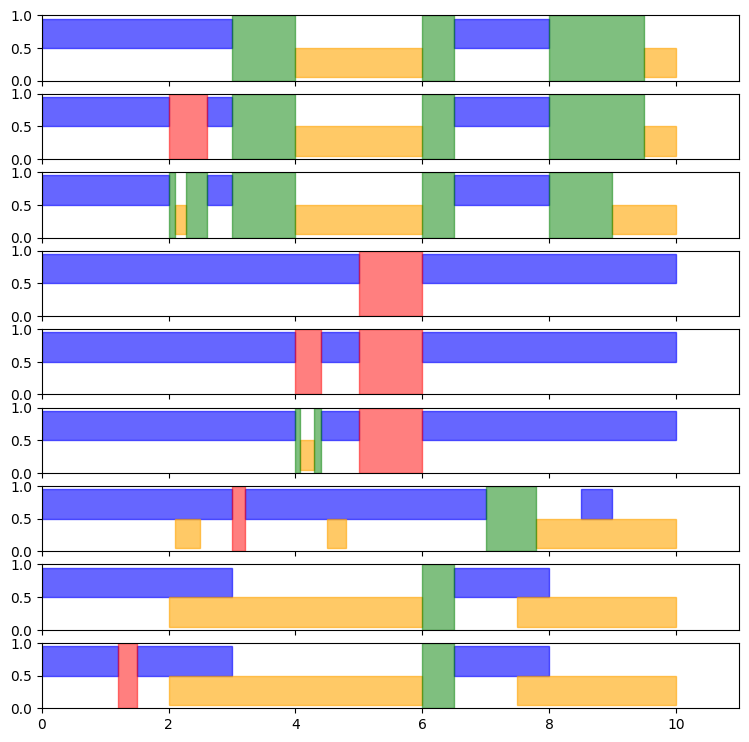

In [9]:
hold, shift = get_hold_shift_candidates(vad)
plot_events_batch(vad, {"shift": shift, "hold": hold})

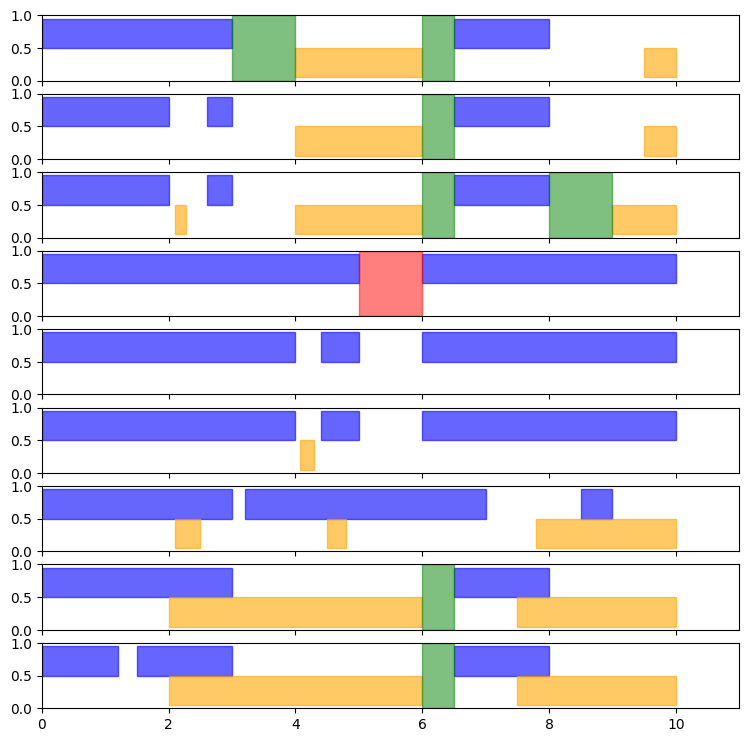

In [10]:
hold, shift = HoldShiftEvents(condition="strict")(vad)
plot_events_batch(vad, {"shift": shift, "hold": hold})

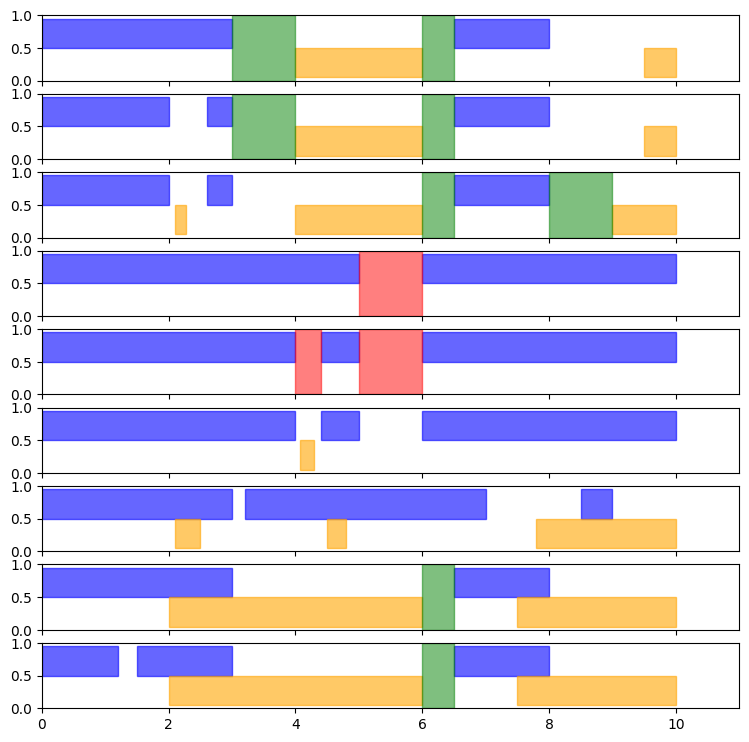

In [11]:
hold, shift = HoldShiftEvents(condition="pause_inclusion")(vad)
plot_events_batch(vad, {"shift": shift, "hold": hold})